# Introduction
Glad to have you reading this work. What you're seeing here is topic modeling projected created to show capabilities using python and related viz. I gathered some old tweet data with the aim of explore the followig question: 

<H4 style="text-align: center;">What are the topics in these tweets?</H4>

# Process
Topic modeling is a big messy. I'll walk you through the work, but here's a summary:

1. Setting up the environment
2. Loading the Data
3. Exploring the data
4. Pre-processing the data
5. Exploring topic modeling methods
6. Visulizing the results
7. Discussing what we can learn from the results.

### Virtual Environment
The env is available in the `tweet_topic_modeling_environment.yml` and was output in this way via command line:

* !`conda env export --from-history > tweet_topic_modeling_environment.yml`.

See [creating-an-environment-from-an-environment-yml-file](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) on Conda's site to load the even. 

Side note: 
As I was adding packages to teh environment, I found it useful to add conda-forge to my channels
* `conda config --add channels conda-forge`
* `conda config --set channel_priority strict`
  
### kernel
After activating the conda environment, make the kernel accessible (see [stackoverflow](https://stackoverflow.com/a/44786736)):
* !`python -m ipykernel install --user --name tweet_topic_modeling --display-name "tweet_topic_modeling"`

### IDE
Jupyter Lab is used and the "tweet_topic_modeling" kernel is selected. 

* !`jupyter lab`

### Data
Post Elon, the site formerly known as Twitter no longer makes tweet data freely available. So I am using data from one of my topic modeling projects from 2015 (see my [topic-modeling-201](https://github.com/DrSkippy/Data-Science-45min-Intros/tree/master/topic-modeling-201) repo). The data is 5000 tweets using the search term "golden retreiver" that was freely snagged from Twitter's public API in 2015. However, as you'll see below over 80% of the tweets were roughly the same content; so ...I improvised with some edits inspired by the DataViz team members and Tom Robbins writing style. 
### Pip

After activating the env, I had to use `pip` to install a few libs that `conda` wouldn't give me at least on this machine:

* `python -m pip install langid langdetect torch gensim huggingface-hub langdetect langid nodejs pyLDAvis seaborn wordcloud nltk`

### Explore Original Data 
Note: I add a second data set here called "replaced_tweets".

* Over 80% of the original tweets contain "half pitbull half goden retriever
* Less than 10% of the original tweets are unique. 
* (accomplished below) We can bump that up to almost 90% uniqueness using some replacement text.
* (accomplished below) Once we clean the URLS and @mentions, we only retain about 25% uniqueness. (The unique urls and @mentions account for much of the uniqueness) 

In [1]:
import pickle as pkl
with open('data/tweet_text.pkl', 'rb') as file:
    tweet_text = pkl.load(file)

from models.viz.utils import get_replaced_tweets
replaced_tweets = get_replaced_tweets()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from collections import Counter
print("-------------ORGINAL TWEET SET: MOST COMMON TWEETS-------------)")
Counter(tweet_text).most_common(5)

-------------ORGINAL TWEET SET: MOST COMMON TWEETS-------------)


[('RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
  1824),
 ('RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
  1387),
 ('RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
  672),
 ('RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
  95),
 ('RT @RetrieverPics: half pitbull half golden retriever https://t.co/q3wkO6mbtZ',
  60)]

In [3]:
import random
print("-------------ORIGINAL TWEETS (sampled)-------------)")
random.sample(tweet_text, 10)

-------------ORIGINAL TWEETS (sampled)-------------)


['RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR']

In [4]:
import re
# Count the number of tweets containing the phrase "half pitbull half golden retriever"
count = sum(1 for tweet in tweet_text if re.search(r'half\s+pitbull\s+half\s+golden\s+retriever', tweet, flags=re.IGNORECASE))

# Output the count
print(f"Tweets containing 'half pitbull half golden retriever': {count}/5000 (>80%)")

Tweets containing 'half pitbull half golden retriever': 4147/5000 (>80%)


In [5]:
print(f'percent of original tweets unique: {100*len(set(tweet_text))/len(tweet_text)}%')

percent of original tweets unique: 8.96%


In [6]:
print(f'percent of replaced tweets unique: {100*len(set(replaced_tweets))/len(replaced_tweets)}%') 

percent of replaced tweets unique: 84.72%


In [7]:
#from collections import Counter
#print("-------------UPDATED TWEET SET: MOST COMMON TWEETS-------------)")
#Counter(replaced_tweets).most_common(5)

# **Apple DataViz Team Special Edition** (for funsies) 
Since most of these tweets contain the term "half pitbull half golden retriever," I replaced this phrase with some Tom Robbins style whimsy along with the names of my potential DataViz teammates. We'll see what topics emerge now, but I'm changing my main question to:

<H4 style="text-align: center;">What can I learn about Adila, Patrick, and Sesh in these tweets?</H4>

In [8]:
from data.utils.data_processing import process_tweets

run = True
if run: 
    replaced_tweets = process_tweets(tweet_text)
    with open('data/whimsy_tweets.pkl','wb') as f:
        pkl.dump(replaced_tweets, f, protocol=pkl.HIGHEST_PROTOCOL)

### show updated tweet set
for tweet in random.sample(replaced_tweets, 5): 
    print(tweet)
    


RT @PitbuIIs: half enchanting gargoyle riding on rainbow unicorns half Sesh https://t.co/5Q8blK2MHR
RT @BabyAnimalPics: half radiant sunflower surfing on rainbows half Adila https://t.co/86vpNGZ9mr
RT @Goals4Dudes: half fantastical whirlpool dancing with auroras half Sesh https://t.co/MNf647Tr6r
RT @BabyAnimalPics: half whimsical gazelle surfing on rainbows half Adila https://t.co/86vpNGZ9mr
RT @BabyAnimalPics: half surreal sphinx juggling thunderbolts half Patrick https://t.co/86vpNGZ9mr


### Intial Thoughts on the data
1. The RT in the text is an outdated way of establishing that a tweet is actually a retweet; so I plan to remove it from the txt b/c it's not relevant to the topcs. 
2. In the first 10 tweets I vieweed, 8 had links, but only 1 link took me to a non-deleted tweet from a non-suspended user.
    * What should I do with links in general?
        * I will remove them to focus purely on the text. 
    * What should I do with suspended user content?
        * For the purpose of this topic modeling exercise, I'm not concerned that automated bots or humans made the content.
3. The @ mentions should be removed to clean the text. I don't want these to muddle up the topics. 
4. Punctuation could be removed to clean the text, but I may use BERT so I'll have to make that flexible. 
5. Should we start with stemming? I want to see where this goes without it first b/c we have a unique word selections. 


### ChatGPT Prompt 

I decided to try whatever ChatGPT had to offer. 

**initial promp**: "I have text from 5000 tweets in a python list variable named "tweet_text".  The text was pulled from a 2015 version of Twitter's free public API using "golden retriever" as the search term. I'd like to remove urls, remove the word "RT", remove punctuation from the text, and remove common stop words. I'd also like to lowercase all of the text, and use stemming. Can you clean this data accordingly, split this list into a train and test set, train a topic model on the training set, and then label the test set using the topic model?"

### Run once

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lehman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lehman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Model 1: LDA 
* label is "**LDA_m1**":

* lda_model = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                                id2word=dictionary,
                                                num_topics=5,
                                                random_state=42,
                                                passes=10,
                                                per_word_topics=True)
* Setting are just a starting point and I didn't adjust `alpha_value` nor `beta_value`. 

In [10]:
import models.LDA_m1 as LDA_m1
from models.viz.utils import get_replaced_tweets
    
lda_model, coherence_lda, test_texts, test_topic_labels = LDA_m1.main(get_replaced_tweets())

# Display results
print('LDA Model:')
print(lda_model)
print('Coherence Score:', coherence_lda)
print('Test Results:')
for i in range(5):  # Print labels for the first 5 test tweets
    print("Test tweet:", test_texts[i])
    print("Topic label:", test_topic_labels[i])
    print("")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Thoughts on topics
1. I need more details about what the topics mean.

### ChatGPT Prompt Update

I have text from 5000 tweets in a python list variable named "tweet_text".  The text was pulled from a 2015 version of Twitter's free public API using "golden retriever" as the search term. I'd like to remove urls, remove the words that start with @ (these are the user mentions), remove the word "RT", remove punctuation from the text, and remove common stop words. I'd also like to lowercase all of the text, ~and use stemming~. Can you clean this data accordingly, split this list into a train and test set, train a topic model on the training set, and then label the test set using the topic model?

### Model 2: LDA 
* label is "**LDA_m2**":

* lda_model = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                                id2word=dictionary,
                                                num_topics=5,
                                                random_state=42,
                                                passes=10,
                                                per_word_topics=True)


In [1]:
import models.LDA_m2 as LDA_m2
import sys
sys.path.append('models/viz')
from models.viz.utils import print_results, get_replaced_tweets
print_results(*LDA_m2.main(get_replaced_tweets()))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


### Thoughts on output 
1. Getting `nan` for the coherence score is a problem likely caused by the small number of umique tweets. I'll bump that number up by making a few replacements. 
1. What size is our dataset including train/test?
   * We went from 5000 tweets to 300 unique tweets.
1. Are the topics very distinct? Meaning, are the probabilities for the tweets predicting one clear winner or are the probabilities roughly equal across all topics?
1. The meaning of the topics is opaque. How can we visualize the results?
   * I recall pyLDAvis was cool, but I'm keen to explore new ways so I'll ask ChatGPT for recs.
1. Language? 
   * For my own purposes, choosing English or Spanish would make the output more understandable to me. I'll choose english.

### choose lang lib
I want the library that leaves me with the most tweets; I'm not going to stress about accuracy at this point, but I just want something to removing tweets not in english. 
* I picked langid b/c it ran faster and left me with more tweets
* The spot check didn't surface anything in either group that seems suspicous 

In [8]:
from langdetect import detect

# Filter out non-English tweets
english_tweets = []
for tweet in tweet_text:
    try:
        if detect(tweet) == 'en':
            english_tweets.append(tweet)
    except:
        pass  # Skip tweets that raise exceptions (e.g., empty tweets)

In [9]:
len(english_tweets)

4066

In [10]:
import random
random.sample(english_tweets, 20)

['RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @JohnNicholRAF: I feel sure my Golden Retriever Ted would love this outfit!! How mad is this? https://t.co/9TT8RffNtN',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 "We know you're out there! But we understand cause they're kinda irresistible \U000fe347 https://t.co/d7TxM37vQm",
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @HighSchoolSuckz: Some days I wish I was a Golden Retriever in an upper class family.',
 'RT @BabyA

In [11]:
import langid

# Filter out non-English tweets
english_tweets_langid = []
for tweet in tweet_text:
    lang, _ = langid.classify(tweet)
    if lang == 'en':
        english_tweets_langid.append(tweet)

print(len(english_tweets_langid))

4664


In [12]:
random.sample(english_tweets_langid, 20)

['RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @AnabellNielsen: sup pup, my baby golden retriever #cute https://t.co/a266XeQsjN',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @RetrieversCare: Until Tuesday: A Wounded Warrior and the Golden Retriever Who Saved Him https://t.co/hrO9Ko83DP #GoldenRetriever #DogsL…',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'Beautiful RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/hEoiQp2nTp',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 '#Health https://t.co

### Run Model with updates

In [13]:
import models.LDA_m3 as LDA_m3
LDA_m3.main(tweet_text, print_results=True)

Test tweet: think need golden retriev puppi
Topic label: 2

Test tweet: person look guy guy own golden retriev
Topic label: 3

Test tweet: golden retriev snuggl bird hamster pic
Topic label: 1

Test tweet: puppi sign tauru golden retriev
Topic label: 2

Test tweet: murphi avail adopt male golden retriev yr old learn
Topic label: 2

Topics and their meanings:
Topic 0: 0.050*"golden" + 0.050*"retriev" + 0.015*"wish" + 0.015*"bulldog" + 0.011*"get" + 0.011*"lab" + 0.011*"na" + 0.011*"famili" + 0.011*"upper" + 0.011*"class"
Topic 1: 0.099*"retriev" + 0.097*"golden" + 0.026*"half" + 0.015*"dog" + 0.014*"cute" + 0.013*"pitbul" + 0.013*"like" + 0.011*"puppi" + 0.010*"get" + 0.009*"name"
Topic 2: 0.100*"retriev" + 0.100*"golden" + 0.037*"half" + 0.017*"pitbul" + 0.017*"puppi" + 0.016*"got" + 0.015*"dog" + 0.012*"want" + 0.011*"realli" + 0.009*"need"
Topic 3: 0.052*"golden" + 0.044*"retriev" + 0.016*"life" + 0.015*"littl" + 0.012*"mix" + 0.012*"ive" + 0.012*"theyr" + 0.012*"first" + 0.011*"thin

### Visualize Results
* My aim here is to explore the topics distinct nature and meaning in a human readable way. 

In [14]:
lda_model, train_corpus, dictionary = LDA_m3.main(tweet_text, pyLDAvis=True)

### Quick Reflections
1. 'Golden' and 'Retriv' may not need to be in the visual; I'll add code to remove it but comment it out for now.
2. Could these topics fit into a customer journey; Golden Retriever being the product taken from awereness to aquisition to loyalty, etc.
3. These visuals don't show the overlap in similarity.
4. Ugh...wordclouds.

In [15]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
lda_display = gensimvis.prepare(lda_model, train_corpus, dictionary, sort_topics=False)
# Display the visualization
pyLDAvis.display(lda_display)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
# import plotly.graph_objects as go

# # Extract topics and associated terms from the LDA model
# topics_terms = lda_model.show_topics(formatted=False)

# # Extract topic-term distributions for each topic
# topic_terms = {idx: [term for term, _ in topic] for idx, topic in topics_terms}

# # Create bar plots for each topic showing the top terms
# fig_terms = go.Figure()
# for idx, terms in topic_terms.items():
#     fig_terms.add_trace(go.Bar(x=terms, y=[1]*len(terms), name=f'Topic {idx}', orientation='h'))

# fig_terms.update_layout(title='Top Terms in Each Topic', barmode='stack', xaxis_title='Term', yaxis_title='Topic')
# fig_terms.show()

# # Extract topic-document distributions for the test set
# topic_distribution_test = [lda_model.get_document_topics(doc) for doc in test_corpus]

# # Create stacked bar plot showing topic distribution in test documents
# fig_distribution = go.Figure()
# for idx, topic_dist in enumerate(topic_distribution_test):
#     probs = [prob for _, prob in topic_dist]
#     fig_distribution.add_trace(go.Bar(x=[f'Topic {i}' for i in range(len(probs))], y=probs, name=f'Document {idx}'))

# fig_distribution.update_layout(title='Topic Distribution in Test Documents', barmode='stack', xaxis_title='Topic', yaxis_title='Probability')
# fig_distribution.show()

In [17]:
topic_terms = {}
for idx, topic in lda_model.print_topics(-1):
    terms = [term.split("*")[1].strip().strip('"') for term in topic.split("+")]
    topic_terms[f"Topic {idx}"] = terms

# Print topic-term distributions
for topic, terms in topic_terms.items():
    print(f"{topic}: {terms}")

topic_terms_with_counts = [{ 'topic': topic, 'count': len(terms) } for topic, terms in topic_terms.items()]


Topic 0: ['golden', 'retriev', 'wish', 'bulldog', 'get', 'lab', 'na', 'famili', 'upper', 'class']
Topic 1: ['retriev', 'golden', 'half', 'dog', 'cute', 'pitbul', 'like', 'puppi', 'get', 'name']
Topic 2: ['retriev', 'golden', 'half', 'pitbul', 'puppi', 'got', 'dog', 'want', 'realli', 'need']
Topic 3: ['golden', 'retriev', 'life', 'littl', 'mix', 'ive', 'theyr', 'first', 'thing', 'need']
Topic 4: ['golden', 'retriev', 'phoenix', 'help', 'look', 'absolut', 'walk', 'adopt', 'guid', 'he']


### Reflection
1. a few of the clusters seemed to overlap on the topic map, but running LDA a few more times let randomness change the positions. 
2. I'm not seeing a rich "theme" in the topic content. I'm going to try to use BERT embeddings to represent the text data and then apply LDA to find topics.

### BERT + LDA thoughts
... 

In [ ]:
from models.viz.utils import visualize_pyldavis
from models import BERT_LDA_m1
lda_model, bow_corpus, lda_dictionary = BERT_LDA_m1.main(tweet_text, wordcloud=True,pyldavis=True)
visualize_pyldavis(lda_model, bow_corpus, lda_dictionary)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
1+1

In [ ]:
import re
import torch
from transformers import BertTokenizer, BertModel
from gensim.corpora import Dictionary
import gensim
import langid
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel

def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    return re.sub(r'http\S+|@\w+|\bRT\b', '', text)

def tokenize_and_embed_tweets(tokenizer, bert_model, tweets):
    """Tokenize and embed tweets using BERT."""
    embeddings = []
    for tweet in tweets:
        encoded_tweet = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**encoded_tweet)
        embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

def train_lda_model(corpus, dictionary):
    """Train an LDA model."""
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,
                                           random_state=42,
                                           passes=10,
                                           per_word_topics=True)

def visualize_wordclouds(lda_model):
    """Visualize Word Clouds for each topic."""
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for topic_id, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis('off')
        plt.show()

def visualize_pyldavis(lda_model, corpus, dictionary):
    """Visualize pyLDAvis."""
    lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

def compute_coherence(lda_model, corpus, dictionary):
    """Compute Topic Coherence."""
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')


# Sample list of 5000 tweet texts
tweet_texts = tweet_text  

# Keep only tweets classified as English
english_tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

# Preprocess and tokenize texts
preprocessed_texts = [preprocess_text(text) for text in english_tweet_texts]

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).eval()

# Tokenize and embed tweets using BERT
bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)

# Convert BERT embeddings to a format suitable for LDA
flattened_bert_embeddings = [emb.flatten() for emb in bert_embeddings]

# Train LDA model on bag-of-words representations
lda_dictionary = Dictionary([word_tokenize(text) for text in preprocessed_texts])
bow_corpus = [lda_dictionary.doc2bow(word_tokenize(text)) for text in preprocessed_texts]
lda_model = train_lda_model(bow_corpus, lda_dictionary)

# Visualizations
visualize_wordclouds(lda_model)
compute_coherence(lda_model, bow_corpus, lda_dictionary, preprocessed_texts)




In [ ]:
def compute_coherence(lda_model, corpus, dictionary, texts):
    """Compute Topic Coherence."""
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')
compute_coherence(lda_model, bow_corpus, lda_dictionary)

### Optimized Code 2.2

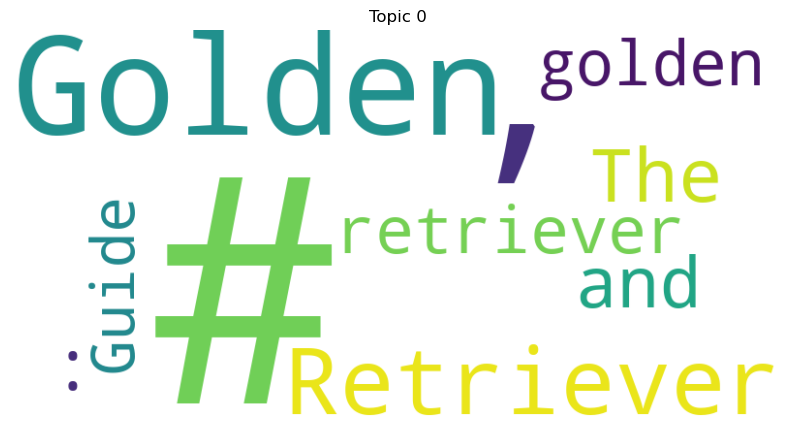

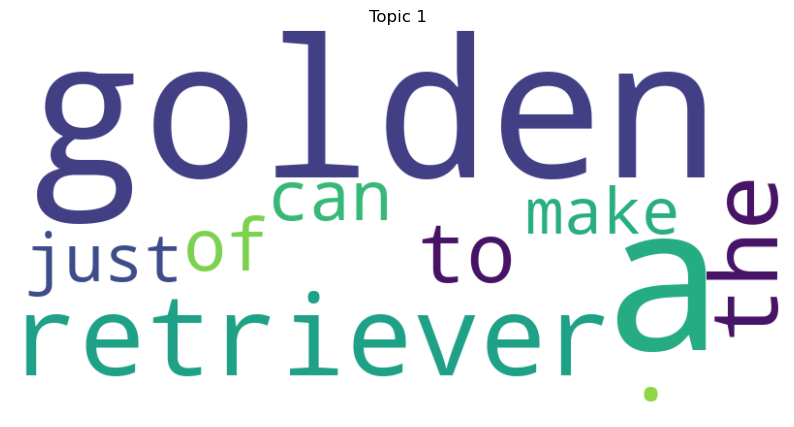

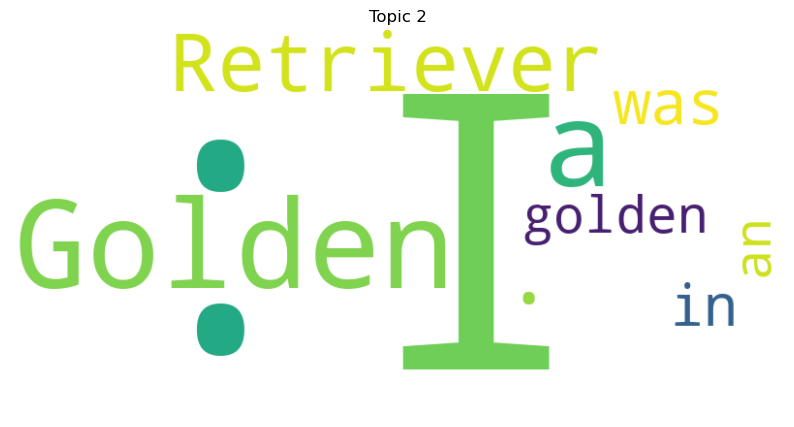

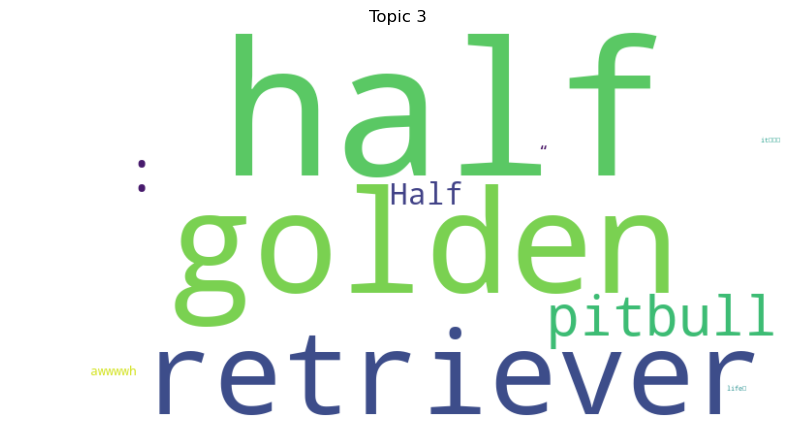

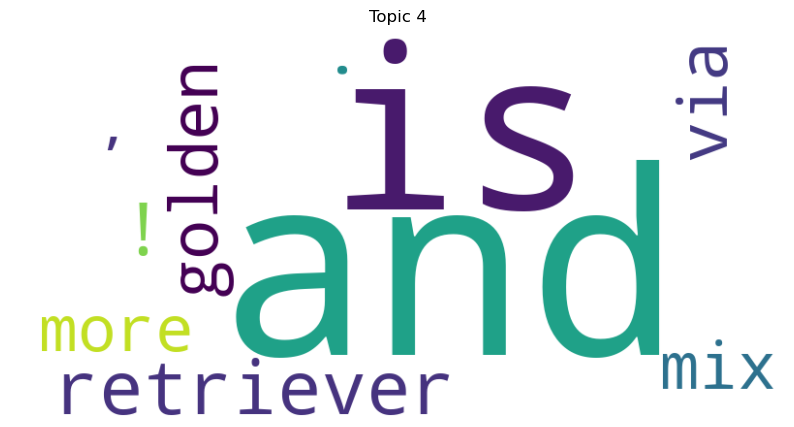

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [4]:
import re
import torch
from transformers import BertTokenizer, BertModel
from gensim.corpora import Dictionary
import gensim
import langid
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel

def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    return re.sub(r'http\S+|@\w+|\bRT\b', '', text)

def tokenize_and_embed_tweets(tokenizer, bert_model, tweets):
    """Tokenize and embed tweets using BERT."""
    embeddings = []
    for tweet in tweets:
        encoded_tweet = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**encoded_tweet)
        embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

def train_lda_model(corpus, dictionary):
    """Train an LDA model."""
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,
                                           random_state=42,
                                           passes=10,
                                           per_word_topics=True)

def visualize_wordclouds(lda_model):
    """Visualize Word Clouds for each topic."""
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for topic_id, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis('off')
        plt.show()

def visualize_pyldavis(lda_model, corpus, dictionary):
    """Visualize pyLDAvis."""
    lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

def compute_coherence(lda_model, corpus, dictionary, texts):
    """Compute Topic Coherence."""
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')


# Sample list of 5000 tweet texts
tweet_texts = tweet_text  

# Keep only tweets classified as English
english_tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

# Preprocess and tokenize texts
preprocessed_texts = [preprocess_text(text) for text in english_tweet_texts]

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).eval()

# Tokenize and embed tweets using BERT
bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)

# Convert BERT embeddings to a format suitable for LDA
flattened_bert_embeddings = [emb.flatten() for emb in bert_embeddings]

# Train LDA model on bag-of-words representations
lda_dictionary = Dictionary([word_tokenize(text) for text in preprocessed_texts])
bow_corpus = [lda_dictionary.doc2bow(word_tokenize(text)) for text in preprocessed_texts]
lda_model = train_lda_model(bow_corpus, lda_dictionary)

# Visualizations
visualize_wordclouds(lda_model)
#visualize_pyldavis(lda_model, bow_corpus, lda_dictionary)
compute_coherence(lda_model, bow_corpus, lda_dictionary, preprocessed_texts)


In [5]:
visualize_pyldavis(lda_model, bow_corpus, lda_dictionary)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:
lda_display = gensimvis.prepare(lda_model, bow_corpus, lda_dictionary)
pyLDAvis.display(lda_display)

### Optimized code 2.1

In [ ]:
import re
import os
import concurrent.futures
from transformers import BertTokenizer, BertModel
import torch
import time
from gensim.corpora import Dictionary
import langid
from sklearn.model_selection import train_test_split
import gensim

def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    text = re.sub(r'http\S+|@\w+|\bRT\b', '', text)
    return text

def load_or_create_tokenizer(model_name, bert_tokenizer_file):
    """Load or create BERT tokenizer."""
    if not os.path.exists(bert_tokenizer_file):
        tokenizer = BertTokenizer.from_pretrained(model_name)
        tokenizer.save_pretrained(bert_tokenizer_file)
    else:
        tokenizer = BertTokenizer.from_pretrained(bert_tokenizer_file)
    return tokenizer

def tokenize_and_embed_tweets(tokenizer, bert_model, tweets):
    """Tokenize and embed tweets using BERT."""
    def process_tweet(tweet):
        encoded_tweet = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**encoded_tweet)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
        return embeddings

    with concurrent.futures.ThreadPoolExecutor() as executor:
        embeddings = list(executor.map(process_tweet, tweets))
    
    return embeddings

def create_lda_dictionary(texts):
    """Create an LDA dictionary."""
    dictionary = Dictionary(texts)
    dictionary.compactify()
    return dictionary

def train_lda_model(corpus, dictionary):
    """Train an LDA model."""
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                 id2word=dictionary,
                                                 num_topics=5,
                                                 random_state=42,
                                                 passes=10,
                                                 per_word_topics=True)
    return lda_model

# Sample list of 5000 tweet texts
tweet_texts = tweet_text  

# Keep only tweets classified as English
english_tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

start = time.time()

# Preprocess and tokenize texts
preprocessed_texts = [preprocess_text(text) for text in english_tweet_texts]

end = time.time()
print("Time taken for text preprocessing:", end - start, "seconds")

start = time.time()

# Load or create BERT tokenizer
model_name = 'bert-tiny-uncased'
bert_tokenizer_file = 'bert_tokenizer.pth'
tokenizer = load_or_create_tokenizer(model_name, bert_tokenizer_file)

# Load BERT model
bert_model = BertModel.from_pretrained(model_name)
bert_model.eval()

# Tokenize and embed tweets
bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)

end = time.time()
print("Time taken to tokenize and embed tweets:", end - start, "seconds")

start = time.time()

# Convert BERT embeddings to a format suitable for LDA
lda_inputs = [emb.flatten() for emb in bert_embeddings]

end = time.time()
print("Time taken for data conversion for LDA:", end - start, "seconds")

start = time.time()

# Split data into train and test sets
train_inputs, test_inputs = train_test_split(lda_inputs, test_size=0.2, random_state=42)

end = time.time()
print("Time taken for data splitting:", end - start, "seconds")

start = time.time()

# Create LDA dictionary
lda_dictionary = create_lda_dictionary(preprocessed_texts)

# Train LDA model
lda_model = train_lda_model(train_inputs, lda_dictionary)

end = time.time()
print("Time taken for LDA model training:", end - start, "seconds")

### Visualize results

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel

# Visualization 1: Word Clouds for each topic
def visualize_wordclouds(lda_model):
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for topic_id, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis('off')
        plt.show()

# Visualization 2: pyLDAvis
def visualize_pyldavis(lda_model, corpus, dictionary):
    lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

# Visualization 3: Topic Coherence
def compute_coherence(lda_model, corpus, dictionary):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=train_tokens, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')



In [ ]:
# Visualize word clouds for each topic
visualize_wordclouds(lda_model)

end = time.time()
print("Time taken for word cloud visualization:", end - start, "seconds")



In [ ]:
start = time.time()

# Visualize topics using pyLDAvis
visualize_pyldavis(lda_model, train_corpus, dictionary)

end = time.time()
print("Time taken for pyLDAvis visualization:", end - start, "seconds")



In [ ]:
start = time.time()

# Compute and print topic coherence score
compute_coherence(lda_model, train_corpus, dictionary)

end = time.time()
print("Time taken for coherence score computation:", end - start, "seconds")

In [8]:
lda_model.num_topics

5